In [1]:
#!/usr/bin/env python
# coding: utf-8
# 모델의 reproducibility를 위해 random seed를 고정함
seed_value = 743
print("Train with random seed", seed_value)

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.set_random_seed(seed_value)
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Train with random seed 743


c:\programdata\anaconda3\envs\at\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\programdata\anaconda3\envs\at\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\programdata\anaconda3\envs\at\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\programdata\anaconda3\envs\at\lib\site-packages\tensorflow\python\framework\dty

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 그래프를 그리기 위한 matplotlib 및 기타 utility 라이브러리를 import함
import pickle
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as font_manager
# matplotlib를 사용해 그래프를 그릴 때 사용할 글꼴을 설정함
font_dirs = ['.']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
matplotlib.rcParams['font.family'] = 'Malgun Gothic'

In [3]:
from sklearn.preprocessing import MinMaxScaler  # 데이터 정규화에 사용할 MinMaxScaler import
from sklearn.metrics import mean_squared_error  # MSE 성능 지표를 계산하기 하기 위한 함수 import

# 모델을 구축하기 위한 keras 관련 함수 import
from keras.models import *
from keras.layers import Lambda, RepeatVector
from keras.layers import Input, multiply
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras import regularizers

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    """MAPE 성능 지표를 계산하기 위한 함수 정의"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
# Define the function to return the SMAPE value
def calculate_smape(actual, predicted) -> float:
    """SMAPE 성능 지표를 계산하기 위한 함수 정의"""
  
    # Convert actual and predicted to numpy
    # array data type if not already
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
  
    return round(
        np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 2
    )

In [6]:
# def calculate_smape(actual, pred):
#     return 1/len(actual) * np.sum(2 * np.abs(pred-actual) / (np.abs(actual) + np.abs(pred))*100)

In [7]:
# 클러스터링을 진행한 CSV 데이터 파일의 path를 설정함
data_filename = '../data/PM10_clustering_result_1010.csv'
detrended_df = pd.read_csv(data_filename)  # Pandas의 read_csv 함수를 이용해 CSV 파일을 읽음

In [8]:
detrended_df.head()

,in_id,0,1,2,3,4,5,6,7,8,...,999,1000,1001,1002,1003,1004,1005,1006,1007,Cluster
0,ICL1L2000011,21.5,22.3,21.8,21.5,21.5,21.1,20.3,21.777778,22.4,...,4.2,4.3,3.6,4.0,3.8,4.0,3.9,4.1,4.3,Cluster -1
1,ICL1L2000017,11.4,11.3,11.3,11.5,11.1,11.8,12.0,12.200000,12.4,...,3.8,3.8,4.4,3.9,3.3,3.6,4.1,5.5,7.2,Cluster -1
2,ICL1L2000064,15.3,15.2,16.1,14.5,16.9,15.3,15.5,15.500000,15.9,...,18.4,17.9,19.8,19.1,19.3,19.8,21.8,20.7,21.7,Cluster -1
3,ICL1L2000065,16.2,16.2,16.6,16.7,16.9,16.6,16.8,17.100000,17.3,...,12.4,12.1,12.5,13.3,13.8,14.0,14.7,14.2,14.8,Cluster -1
4,ICL1L2000234,43.3,43.5,42.5,41.9,42.2,41.8,42.8,42.800000,42.9,...,36.9,36.8,37.2,36.9,37.1,37.5,37.1,37.5,37.0,Cluster 0


In [9]:
detrended_df['Cluster'].value_counts()  # 각 클러스터에 포함된 시계열 데이터의 샘플 수 확인

Cluster -1    103
Cluster 0      17
Cluster 2       7
Cluster 8       5
Cluster 1       4
Cluster 4       4
Cluster 5       3
Cluster 3       3
Cluster 6       3
Cluster 7       3
Name: Cluster, dtype: int64

In [10]:
specific_df = detrended_df[detrended_df['Cluster'] == 'Cluster 2']  # 특정 클러스터의 데이터만 사용함

In [11]:
cluster_row_num = len(specific_df)  # 선택한 클러스터의 시계열 데이터의 샘플 수 계산

In [12]:
def get_split_row_index(total_row, train_split=0.6):
    """DataFrame을 train, test, validation으로 나누기 위한 helper 함수"""
    train_data_up = int(total_row * train_split)
    remain_data_row = cluster_row_num - train_data_up
    
    # test set과 validation set의 row 수가 같도록
    # train, test, valid split을 진행함
    if remain_data_row % 2 == 1:
        train_data_up += 1
        remain_data_row -= 1
    
    valid_data_up = int(remain_data_row / 2)
    
    assert train_data_up + valid_data_up * 2 == total_row
    
    return train_data_up, train_data_up + valid_data_up

In [13]:
train_up_bound, valid_up_bound = get_split_row_index(cluster_row_num)

In [14]:
# 전체 DataFrame을 train, test, validation DataFrame으로 나눔
train_df = specific_df[:train_up_bound]
valid_df = specific_df[train_up_bound:valid_up_bound]
test_df = specific_df[valid_up_bound:]

In [15]:
# train, test, validation DataFrame의 시계열 데이터 샘플 수 확인
print("Train DataFrame row: ", len(train_df))
print("Valid DataFrame row: ", len(valid_df))
print("Test DataFrame row: ", len(test_df))

Train DataFrame row:  5
Valid DataFrame row:  1
Test DataFrame row:  1


In [16]:
assert len(train_df) + len(valid_df) + len(test_df) == cluster_row_num

In [17]:
train_df.head()

,in_id,0,1,2,3,4,5,6,7,8,...,999,1000,1001,1002,1003,1004,1005,1006,1007,Cluster
33,ICL1L2000269,6.2,6.200000,6.7,10.8,10.6,10.2,10.8,10.900000,10.6,...,17.7,18.4,19.8,19.9,21.7,22.3,22.9,24.2,22.9,Cluster 2
37,ICL1L2000275,19.0,18.600000,19.6,19.4,19.1,19.6,18.8,19.222222,19.0,...,29.4,29.0,28.3,29.4,32.0,35.3,36.6,40.1,43.3,Cluster 2
38,ICL1L2000276,18.9,18.111111,18.0,18.0,17.7,17.5,16.6,17.400000,17.1,...,22.4,23.4,24.4,25.3,27.1,27.5,28.2,28.4,29.8,Cluster 2
41,ICL1L2000279,22.7,22.800000,22.8,23.8,24.0,25.3,26.2,28.800000,27.0,...,44.1,44.8,43.4,44.1,43.2,44.2,44.1,43.3,44.3,Cluster 2
42,ICL1L2000280,24.7,25.500000,26.8,28.0,27.0,28.0,29.7,28.800000,29.6,...,31.0,31.0,31.3,30.8,30.4,31.1,30.4,30.2,30.9,Cluster 2


In [18]:
valid_df['in_id'].tolist()  # validation에 사용한 시계열 데이터 샘플의 index id 확인

['ICL1L2000281']

In [19]:
test_df['in_id'].tolist()  # test에 사용한 시계열 데이터 샘플의 index id 확인

['ICL1L2000283']

In [20]:
# DataFrame에서 `in_id` column과 `Cluster` column을 삭제함
train_df = train_df.drop(['in_id', 'Cluster'], axis=1).reset_index(drop=True)
valid_df = valid_df.drop(['in_id', 'Cluster'], axis=1).reset_index(drop=True)
test_df = test_df.drop(['in_id', 'Cluster'], axis=1).reset_index(drop=True)

In [21]:
# 각 DataFrame에 포함된 0 값의 갯 수를 확인함
print("Train Data - Number of 0: ", (train_df == 0).sum().sum())
print("Valid Data - Number of 0: ", (valid_df == 0).sum().sum())
print("Test Data - Number of 0: ", (test_df == 0).sum().sum())

Train Data - Number of 0:  3
Valid Data - Number of 0:  401
Test Data - Number of 0:  0


In [22]:
def dataframe_to_list(data_df):
    """DataFrame을 list로 변환하기 위한 helper 함수 정의"""
    total_data = []  # 전체 데이터 샘플 리스트
    data_list = []  # 데이터 샘플의 리스트
    for i in range(len(data_df)):
        i_row = data_df.loc[i, :].tolist()
        total_data.extend(i_row)
        data_list.append(i_row)
    
    return total_data, data_list

In [23]:
# DataFrame을 list 형태로 변환함
train_data_total, train_data_clusters = dataframe_to_list(train_df)
valid_data_total, valid_data_clusters = dataframe_to_list(valid_df)
test_data_total, test_data_clusters = dataframe_to_list(test_df)

In [24]:
def scale_data_clusters(scaler, data_clusters):
    """Scaler를 사용해 각 시계열 데이터 샘플에 대해 정규화를 진행하는 함수를 정의"""
    std_data_clusters = []
    for data_cluster in data_clusters:
        # scaler의 transform 함수를 사용해 정규화를 진행함
        std_data_cluster = scaler.transform(np.array(data_cluster).reshape(-1, 1))
        std_data_cluster = std_data_cluster.reshape(-1).tolist()
        std_data_clusters.append(std_data_cluster)
    return std_data_clusters

In [25]:
scaler = MinMaxScaler()  # MinMaxScaler 정규화 객체 생성
scaler.fit(np.array(train_data_total).reshape(-1, 1))
# 각 데이터 클러스터에 대해 정규화를 진행함
std_train_data_clusters = scale_data_clusters(scaler, train_data_clusters)
std_valid_data_clusters = scale_data_clusters(scaler, valid_data_clusters)
std_test_data_clusters = scale_data_clusters(scaler, test_data_clusters)

In [26]:
print(len(std_train_data_clusters))

5


In [27]:
def wrap_cluster(data_cluster, window_size=6, look_ahead=6):
    """List 형식의 data_cluster를 사용해 모델 입력을 위한
    (batch_size, window_size, 1) 형식으로 변환함"""
    data_x, data_y = [], []
    assert isinstance(data_cluster, list)
    data_cluster = np.array(data_cluster)
    for i in range(len(data_cluster) - window_size - look_ahead):
        x = data_cluster[i: (i + window_size)]
        y = data_cluster[i + window_size + look_ahead]
        data_x.append(x)  # window_size 만큼의 데이터를 입력으로 사용
        data_y.append(y)  # look_ahead 이후의 데이터를 예측함
    return np.array(data_x).reshape(-1, window_size, 1), np.array(data_y)

In [28]:
sample_cluster = std_train_data_clusters[0][:15]
print(sample_cluster)

[0.05506216696269983, 0.05506216696269983, 0.05950266429840143, 0.09591474245115456, 0.0941385435168739, 0.09058614564831262, 0.09591474245115456, 0.09680284191829487, 0.0941385435168739, 0.08436944937833038, 0.08259325044404975, 0.07371225577264655, 0.06927175843694494, 0.06483126110124335, 0.06927175843694494]


In [29]:
wrap_cluster(sample_cluster)

(array([[[0.05506217],
         [0.05506217],
         [0.05950266],
         [0.09591474],
         [0.09413854],
         [0.09058615]],
 
        [[0.05506217],
         [0.05950266],
         [0.09591474],
         [0.09413854],
         [0.09058615],
         [0.09591474]],
 
        [[0.05950266],
         [0.09591474],
         [0.09413854],
         [0.09058615],
         [0.09591474],
         [0.09680284]]]),
 array([0.06927176, 0.06483126, 0.06927176]))

In [30]:
def create_dataset(data_clusters):
    """wrap_cluster 함수를 이용해 dataset 생성"""
    X, y = [], []
    for data_cluster in data_clusters:
        cluster_X, cluster_y = wrap_cluster(data_cluster)
        X.append(cluster_X)
        y.append(cluster_y)
    
    # np.concatenate 함수를 이용해 여러 게의 numpy array를 하나로 concat 함
    # [(1, window_size, 1), (1, window_size, 1)] -> (2, window_size, 1)
    return np.concatenate(X, axis=0), np.concatenate(y, axis=0)

In [31]:
# train, test, validation 데이터 각각에 대해
# create_dataset 함수를 사용해 데이터 셋을 생성함
train_X, train_y = create_dataset(std_train_data_clusters)
valid_X, valid_y = create_dataset(std_valid_data_clusters)
test_X, test_y = create_dataset(std_test_data_clusters)

In [32]:
print(train_X.shape, train_y.shape)
print(valid_X.shape, valid_y.shape)
print(test_X.shape, test_y.shape)

(4980, 6, 1) (4980,)
(996, 6, 1) (996,)
(996, 6, 1) (996,)


In [33]:
def lstm_model(batch_size, time_step, feature_num):
    """LSTM 모델 정의"""
    inputs = Input(shape=(time_step, feature_num))
    x = LSTM(6, activation='tanh',
             stateful=False,
             return_sequences=True,
             kernel_initializer='he_normal')(inputs)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(10, activation='linear', kernel_regularizer=regularizers.l2(0.01),
              activity_regularizer=regularizers.l1(0.))(x)
    output = Dense(1, activation='linear', kernel_initializer='he_normal')(x)

    model = Model(input=[inputs], output=output)
    return model

In [34]:
# 하이퍼 파라미터 정의
batch_size = 4
look_back = 6
feature_num = 1

# LSTM 모델을 생성하고 compile를 진행함
model = lstm_model(batch_size, look_back, feature_num)
model.compile(loss='mean_squared_error', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [35]:
# 모델 훈련 진행
# 훈련 과정의 손실값을 history 변수에 저장
history = model.fit(train_X, train_y,
                    validation_data=(valid_X, valid_y),
                    batch_size=batch_size, epochs=10)

Instructions for updating:
Use tf.cast instead.
Train on 4980 samples, validate on 996 samples
Epoch 1/10
4980/4980 [==============================] - 4s 732us/step - loss: 0.0387 - val_loss: 0.0027
Epoch 2/10
4980/4980 [==============================] - 3s 642us/step - loss: 0.0057 - val_loss: 0.0017
Epoch 3/10
4980/4980 [==============================] - 3s 636us/step - loss: 0.0052 - val_loss: 0.0014
Epoch 4/10
4980/4980 [==============================] - 3s 634us/step - loss: 0.0050 - val_loss: 0.0011
Epoch 5/10
4980/4980 [==============================] - 3s 634us/step - loss: 0.0049 - val_loss: 0.0011
Epoch 6/10
4980/4980 [==============================] - 3s 635us/step - loss: 0.0048 - val_loss: 0.0012
Epoch 7/10
4980/4980 [==============================] - 3s 633us/step - loss: 0.0046 - val_loss: 0.0013
Epoch 8/10
4980/4980 [==============================] - 3s 635us/step - loss: 0.0046 - val_loss: 0.0014
Epoch 9/10
4980/4980 [==============================] - 3s 622us/step - l

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']

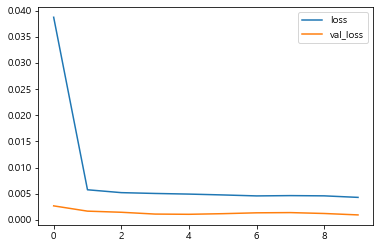

In [37]:
# train loss와 validation loss의 변화를 matplotlib를 사용해 시각화함
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()

In [38]:
# 훈련한 모델을 사용해 예측을 진행함
train_predict = model.predict(train_X, batch_size)
valid_predict = model.predict(valid_X, batch_size)
test_predict = model.predict(test_X, batch_size)

In [39]:
# 성능 측정을 위해 예측한 값에 대해 inverse transform을 진행함
inv_train_y = scaler.inverse_transform(train_y.reshape(-1, 1))
inv_train_predict = scaler.inverse_transform(train_predict)

In [40]:
inv_valid_y = scaler.inverse_transform(valid_y.reshape(-1, 1))
inv_valid_predict = scaler.inverse_transform(valid_predict)

In [41]:
inv_test_y = scaler.inverse_transform(test_y.reshape(-1, 1))
inv_test_predict = scaler.inverse_transform(test_predict)

In [42]:
# train, test, validation set에 대해 MAPE 계산
train_mape = mean_absolute_percentage_error(inv_train_y, inv_train_predict)
valid_mape = mean_absolute_percentage_error(inv_valid_y, inv_valid_predict)
test_mape = mean_absolute_percentage_error(inv_test_y, inv_test_predict)

In [43]:
print("Train MAPE: %.2f" % train_mape)
print("Valid MAPE: %.2f" % valid_mape)
print("Test MAPE: %.2f" % test_mape)

Train MAPE: inf
Valid MAPE: inf
Test MAPE: 16.06


In [44]:
# train, test, validation set에 대해 SMAPE 계산
train_smape = calculate_smape(inv_train_y, inv_train_predict)
valid_smape = calculate_smape(inv_valid_y, inv_valid_predict)
test_smape = calculate_smape(inv_test_y, inv_test_predict)

In [45]:
print("Train SMAPE: %.2f" % train_smape)
print("Valid SMAPE: %.2f" % valid_smape)
print("Test SMAPE: %.2f" % test_smape)

Train SMAPE: 18.76
Valid SMAPE: 122.90
Test SMAPE: 15.85


In [46]:
# train, test, validation set에 대해 MSE 계산
train_mse = mean_squared_error(inv_train_y, inv_train_predict)
valid_mse = mean_squared_error(inv_valid_y, inv_valid_predict)
test_mse = mean_squared_error(inv_test_y, inv_test_predict)

In [47]:
print("Train MSE: %.2f" % train_mse)
print("Valid MSE: %.2f" % valid_mse)
print("Test MSE: %.2f" % test_mse)

Train MSE: 40.78
Valid MSE: 5.41
Test MSE: 40.13


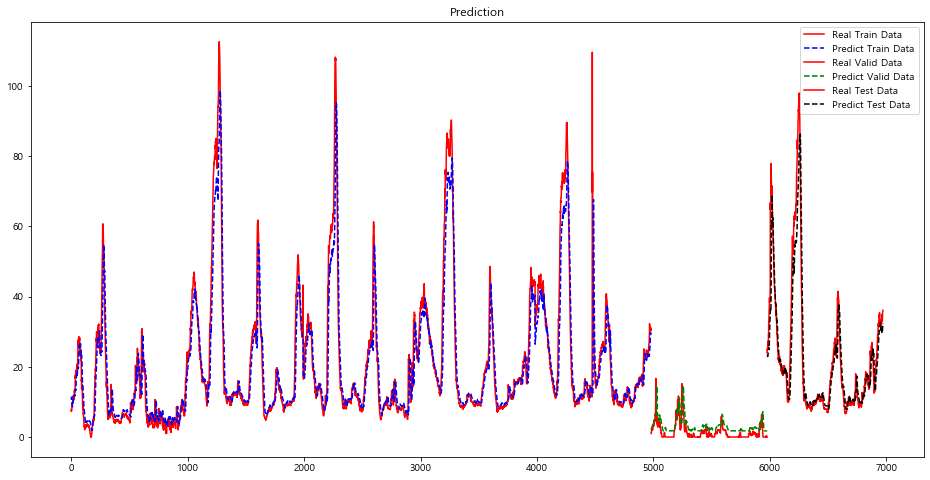

In [48]:
# matplotlib을 이용해 train, test, validation set에 대한 실제값과 예측값을 시각화함
train_term = len(inv_train_y)
valid_term = len(inv_train_y) + len(inv_valid_y)
total_sample = len(inv_train_y) + len(inv_valid_y) + len(inv_test_y)

plt.figure(figsize=(16, 8))
plt.plot(np.arange(train_term), inv_train_y, color='red', ls='-', label='Real Train Data')
plt.plot(np.arange(train_term), inv_train_predict, color='blue', ls='--', label='Predict Train Data')
plt.plot(np.arange(train_term, valid_term), inv_valid_y, color='red', ls='-', label='Real Valid Data')
plt.plot(np.arange(train_term, valid_term), inv_valid_predict, color='green', ls='--', label='Predict Valid Data')
plt.plot(np.arange(valid_term, total_sample), inv_test_y, color='red', ls='-', label='Real Test Data')
plt.plot(np.arange(valid_term, total_sample), inv_test_predict, color='black', ls='--', label='Predict Test Data')
plt.title('Prediction')
plt.legend()